## Crowd Counter Model
Import needed libraries

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, Lambda, ToTensor
import warnings
# Suppress the specific UserWarning
warnings.filterwarnings("ignore", message="The default value of the antialias parameter.*", category=UserWarning)

device = torch.device("cuda:10") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# Define the transformation for the images (you can customize this based on your needs)
test_size = (512,512)
out_size = (64,64)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(test_size),
])

# Define a custom dataset class
class CrowdDataset(torch.utils.data.Dataset):
    def __init__(self, root='jhu_crowd_v2.0/', split='train', transform=None):
        self.input_folder = os.path.join(root, split, 'images')
        self.output_folder = os.path.join(root, split, 'den')
        self.input_dataset = datasets.ImageFolder(self.input_folder, transform=transform)
        self.classes = self.input_dataset.classes
        self.indices = list(range(len(self.input_dataset)))

    def __getitem__(self, index):
        # Load input image
        input_data = self.input_dataset[self.indices[index]][0]  # [0] to get the data (image)

        # Load output data from CSV file
        image_name = os.path.basename(self.input_dataset.imgs[self.indices[index]][0])
        csv_path = os.path.join(self.output_folder, f"{image_name.replace('.jpg', '.csv')}")
        df = pd.read_csv(csv_path, header=None)
        original_data = torch.tensor(df.values).float()
        resized_tensor = F.interpolate(original_data.unsqueeze(0).unsqueeze(0), size=out_size, mode='bilinear', align_corners=False)
        resized_tensor = resized_tensor.squeeze(0).squeeze(0)
        output_data = resized_tensor * (original_data.sum() / resized_tensor.sum())
        return {'input': input_data, 'output': output_data}


    def __len__(self):
        return len(self.indices)


In [4]:
# make all the datasets
train_dataset = CrowdDataset(split='train', transform=transform)
val_dataset = CrowdDataset(split='val', transform=None)
test_dataset = CrowdDataset(split='test', transform=None)

In [5]:
#make a dataloader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [53]:
#loop throough first 10 batches
for i, batch in enumerate(train_dataloader):
    if i == 10:
        break
    print(batch['input'].shape, batch['output'].shape)

torch.Size([8, 3, 512, 512]) torch.Size([8, 64, 64])
torch.Size([8, 3, 512, 512]) torch.Size([8, 64, 64])
torch.Size([8, 3, 512, 512]) torch.Size([8, 64, 64])
torch.Size([8, 3, 512, 512]) torch.Size([8, 64, 64])
torch.Size([8, 3, 512, 512]) torch.Size([8, 64, 64])
torch.Size([8, 3, 512, 512]) torch.Size([8, 64, 64])
torch.Size([8, 3, 512, 512]) torch.Size([8, 64, 64])
torch.Size([8, 3, 512, 512]) torch.Size([8, 64, 64])
torch.Size([8, 3, 512, 512]) torch.Size([8, 64, 64])
torch.Size([8, 3, 512, 512]) torch.Size([8, 64, 64])


In [6]:
class UrebBlock(nn.Module):
    def __init__(self, in_channels):
        super(UrebBlock, self).__init__()
        self.CB = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # Add padding to keep the spatial dimensions
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),   # Add padding to keep the spatial dimensions
        )
        self.DR = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # Add padding to keep the spatial dimensions
        )
        self.CEB = nn.Sequential(
            nn.Conv2d(33, 32, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),  # Add padding to keep the spatial dimensions
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),   # Add padding to keep the spatial dimensions
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),   # Add padding to keep the spatial dimensions
        )
    def forward(self, x):
        r = self.CB(x)
        cm = self.CEB(torch.cat((r, self.DR(x)), dim=1))
        return cm * r
        

In [50]:
class VGGadjusted(nn.Module):
    def __init__(self):
        super(VGGadjusted, self).__init__()
        self.vgg = models.vgg16(weights=None).features
        self.C3 = self.vgg[:17]
        self.C4 = self.vgg[17:24]
        self.C5 = self.vgg[24:]
        self.C6 = nn.Sequential(
            nn.Conv2d(512, 32, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # Add padding to keep the spatial dimensions
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),   # Add padding to keep the spatial dimensions
            nn.Upsample(size=(16, 16), mode='bilinear', align_corners=False)
        )
        self.ureb3 = UrebBlock(256)
        self.ureb4 = UrebBlock(512)
        self.ureb5 = UrebBlock(512)

        self.y5_upsample = nn.Upsample(size=(32, 32), mode='bilinear', align_corners=False)
        self.y4_upsample = nn.Upsample(size=(64, 64), mode='bilinear', align_corners=False)

    def forward(self, x):
        c3 = self.C3(x)
        r3 = self.ureb3(c3)
        c4 = self.C4(c3)
        r4 = self.ureb4(c4)
        c5 = self.C5(c4)
        r5 = self.ureb5(c5)
        y6 = self.C6(c5)
        y5 = y6 + r5
        y4 = self.y5_upsample(y5) + r4
        y3 = self.y4_upsample(y4) + r3
        out = {'y3': y3, 'y4': y4, 'y5': y5, 'y6': y6, 'cm3': r3, 'cm4': r4, 'cm5': r5, }
        return out



In [54]:
class LossFunction(nn.Module):
    def __init__(self):
        super(LossFunction, self).__init__()
        self.lambda_c = -0.001
        self.cm_keys = ['cm3', 'cm4', 'cm5']
        self.y_keys = ['y3', 'y4', 'y5']

    def _scale_regularize_tensor(self, tensor, out_size):
        # print(tensor.shape)
        # print(tuple(list(out_size)[1:]))
        out_size = tuple(list(out_size)[1:])
        # print(tensor.unsqueeze(0).shape)
        resized = F.interpolate(tensor.unsqueeze(0), size=out_size, mode='bilinear', align_corners=False)
        resized = resized.squeeze(0).squeeze(0)
        scaled_tensor = resized * (tensor.sum() / resized.sum())
        return scaled_tensor

    def forward(self, y_hat, y):
        # print(y_hat['cm3'].shape)
        # print(y_hat['cm3'])
        std_dev = 0.1
        loss_C = sum(torch.log(torch.relu(y_hat[cm_key]) + torch.abs(torch.randn_like(y_hat[cm_key]) * std_dev) ).mean() for cm_key in self.cm_keys)
        # print("predicted", (y_hat['cm3'] * y_hat['y3']).shape)
        # print("actual", (y_hat['cm3'] * self._scale_regularize_tensor(y, y_hat['cm3'].squeeze(1).shape).unsqueeze(1)).shape)
        loss_d = sum(F.mse_loss(y_hat[cm_key] * y_hat[y_key], y_hat[cm_key] * self._scale_regularize_tensor(y, y_hat[cm_key].squeeze(1).shape).unsqueeze(1)) for y_key, cm_key in list(zip(self.y_keys, self.cm_keys)))

        print('loss_C', loss_C)
        print('loss_d', loss_d)
        
        return loss_d + self.lambda_c * loss_C


In [55]:
model = VGGadjusted().to(device)
optimizer = AdamW(model.parameters(), lr=1e-4)
criterion = LossFunction()
epochs = 1
loop = tqdm(total=len(train_dataloader)*epochs, position=0, leave=False)
val_loss = []
train_loss = []

In [56]:
def training():
    model.train()
    checkpoint = {
        'epoch': 0,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': 0.0,
    }
    for epoch in range(epochs):
        for i, batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            input_data = batch['input'].to(device)
            output_data = batch['output'].to(device)
            output_pred = model(input_data)
            loss = criterion(output_pred, output_data)
            loss.backward()
            if i % 10 == 0:
                train_loss.append(loss.item())
                # val_loss.append()
            optimizer.step()
            loop.set_description(f"Epoch [{epoch}/{epochs}]")
            loop.set_postfix(loss=loss.item())
            loop.update(1)
        checkpoint['epoch'] = epoch
        checkpoint['model_state_dict'] = model.state_dict()
        checkpoint['optimizer_state_dict'] = optimizer.state_dict()
        checkpoint['loss'] = loss.item()
        torch.save(checkpoint, f'checkpoint_{epoch}.pth')
    loop.close()
training()

Epoch [0/1]:   0%|          | 0/284 [00:03<?, ?it/s]

loss_C tensor(-8.7292, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(9.8943e-06, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   1%|          | 2/284 [00:04<09:58,  2.12s/it, loss=0.0115] 

loss_C tensor(-8.5799, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(0.0029, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   1%|          | 3/284 [00:05<07:27,  1.59s/it, loss=0.00872]

loss_C tensor(-8.6599, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(6.3362e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   1%|▏         | 4/284 [00:07<08:01,  1.72s/it, loss=0.00871]

loss_C tensor(-8.6691, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(4.0493e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   1%|▏         | 4/284 [00:10<08:01,  1.72s/it, loss=0.037]  

loss_C tensor(-8.6805, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(0.0284, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   2%|▏         | 6/284 [00:11<08:44,  1.89s/it, loss=0.00882]

loss_C tensor(-8.7827, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(3.9668e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   2%|▏         | 7/284 [00:14<09:19,  2.02s/it, loss=0.00875]

loss_C tensor(-8.7234, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(2.2915e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   3%|▎         | 8/284 [00:15<08:42,  1.89s/it, loss=0.00869]

loss_C tensor(-8.6849, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(8.8575e-06, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   3%|▎         | 9/284 [00:17<07:59,  1.74s/it, loss=0.0087] 

loss_C tensor(-8.6944, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(6.7447e-06, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   4%|▎         | 10/284 [00:18<08:01,  1.76s/it, loss=0.00876]

loss_C tensor(-8.6949, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(6.5327e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   4%|▍         | 11/284 [00:21<09:00,  1.98s/it, loss=0.0101] 

loss_C tensor(-8.6522, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(0.0014, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   4%|▍         | 12/284 [00:23<09:34,  2.11s/it, loss=0.00873]

loss_C tensor(-8.6614, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(7.0171e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   5%|▍         | 13/284 [00:25<08:27,  1.87s/it, loss=0.00872]

loss_C tensor(-8.6944, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(2.5231e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   5%|▍         | 14/284 [00:26<08:07,  1.80s/it, loss=0.00865]

loss_C tensor(-8.6487, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(3.0733e-06, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   5%|▌         | 15/284 [00:28<08:34,  1.91s/it, loss=0.00879]

loss_C tensor(-8.5984, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(0.0002, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   6%|▌         | 16/284 [00:30<07:59,  1.79s/it, loss=0.00859]

loss_C tensor(-8.5813, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(7.4283e-06, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   6%|▌         | 17/284 [00:32<07:40,  1.72s/it, loss=0.00858]

loss_C tensor(-8.5334, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(4.6574e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   6%|▋         | 18/284 [00:33<06:53,  1.55s/it, loss=0.0086] 

loss_C tensor(-8.5640, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(3.5869e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   7%|▋         | 19/284 [00:36<08:35,  1.94s/it, loss=0.0142]

loss_C tensor(-8.4618, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(0.0057, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   7%|▋         | 20/284 [00:37<07:53,  1.79s/it, loss=0.00861]

loss_C tensor(-8.6083, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(2.4987e-06, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   7%|▋         | 21/284 [00:38<07:09,  1.63s/it, loss=0.00859]

loss_C tensor(-8.5881, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(3.0930e-06, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   8%|▊         | 22/284 [00:40<07:01,  1.61s/it, loss=0.0087] 

loss_C tensor(-8.6568, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(4.6040e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   8%|▊         | 23/284 [00:41<06:12,  1.43s/it, loss=0.00865]

loss_C tensor(-8.6481, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(2.4285e-06, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   8%|▊         | 24/284 [00:42<05:57,  1.37s/it, loss=0.00865]

loss_C tensor(-8.6440, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(7.6799e-06, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   9%|▉         | 25/284 [00:44<06:15,  1.45s/it, loss=0.0087] 

loss_C tensor(-8.6939, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(5.4381e-06, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:   9%|▉         | 26/284 [00:45<06:18,  1.47s/it, loss=0.00862]

loss_C tensor(-8.6100, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(1.4535e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  10%|▉         | 27/284 [00:47<06:21,  1.49s/it, loss=0.00863]

loss_C tensor(-8.6145, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(1.8458e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  10%|▉         | 28/284 [00:48<06:22,  1.49s/it, loss=0.00863]

loss_C tensor(-8.6135, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(1.5220e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  10%|█         | 29/284 [00:50<06:21,  1.50s/it, loss=0.00858]

loss_C tensor(-8.5806, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(3.6131e-06, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  11%|█         | 30/284 [00:52<07:12,  1.70s/it, loss=0.0087] 

loss_C tensor(-8.5630, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(0.0001, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  11%|█         | 31/284 [00:53<06:35,  1.57s/it, loss=0.00859]

loss_C tensor(-8.5815, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(9.2252e-06, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  11%|█▏        | 32/284 [00:55<06:41,  1.59s/it, loss=0.00856]

loss_C tensor(-8.5349, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(2.1016e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  12%|█▏        | 33/284 [00:56<06:44,  1.61s/it, loss=0.00855]

loss_C tensor(-8.5303, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(1.9941e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  12%|█▏        | 34/284 [00:58<06:54,  1.66s/it, loss=0.00853]

loss_C tensor(-8.5076, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(2.0384e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  12%|█▏        | 35/284 [01:00<07:15,  1.75s/it, loss=0.00854]

loss_C tensor(-8.4552, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(8.3306e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  13%|█▎        | 36/284 [01:02<06:53,  1.67s/it, loss=0.00864]

loss_C tensor(-8.4236, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(0.0002, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  13%|█▎        | 37/284 [01:03<06:45,  1.64s/it, loss=0.00844]

loss_C tensor(-8.4171, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(1.8882e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  13%|█▎        | 38/284 [01:05<06:27,  1.57s/it, loss=0.00842]

loss_C tensor(-8.3893, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(2.7404e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  14%|█▎        | 39/284 [01:06<06:35,  1.62s/it, loss=0.00843]

loss_C tensor(-8.3824, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(4.5321e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  14%|█▍        | 40/284 [01:08<06:01,  1.48s/it, loss=0.00838]

loss_C tensor(-8.3721, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(1.1234e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  14%|█▍        | 41/284 [01:09<06:10,  1.52s/it, loss=0.00824]

loss_C tensor(-8.1994, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(3.8774e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  15%|█▍        | 42/284 [01:12<07:18,  1.81s/it, loss=0.0126] 

loss_C tensor(-8.2263, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(0.0043, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  15%|█▌        | 43/284 [01:13<06:23,  1.59s/it, loss=0.00831]

loss_C tensor(-8.2862, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(2.8764e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  15%|█▌        | 44/284 [01:14<05:37,  1.41s/it, loss=0.00834]

loss_C tensor(-8.3272, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(1.7277e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  16%|█▌        | 45/284 [01:15<05:40,  1.42s/it, loss=0.00864]

loss_C tensor(-8.3499, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(0.0003, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  16%|█▌        | 46/284 [01:17<06:13,  1.57s/it, loss=0.00841]

loss_C tensor(-8.3901, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(1.7633e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  17%|█▋        | 47/284 [01:19<06:20,  1.61s/it, loss=0.00838]

loss_C tensor(-8.3176, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(6.4498e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  17%|█▋        | 48/284 [01:20<05:59,  1.52s/it, loss=0.00873]

loss_C tensor(-8.3807, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(0.0003, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  17%|█▋        | 49/284 [01:21<05:31,  1.41s/it, loss=0.00845]

loss_C tensor(-8.4351, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(1.3090e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  18%|█▊        | 50/284 [01:23<05:23,  1.38s/it, loss=0.00846]

loss_C tensor(-8.4281, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(2.7731e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  18%|█▊        | 51/284 [01:24<05:21,  1.38s/it, loss=0.00854]

loss_C tensor(-8.4644, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(7.1275e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  18%|█▊        | 52/284 [01:26<05:49,  1.51s/it, loss=0.00841]

loss_C tensor(-8.3550, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(5.5711e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  19%|█▊        | 53/284 [01:27<05:55,  1.54s/it, loss=0.00871]

loss_C tensor(-8.3775, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(0.0003, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  19%|█▉        | 54/284 [01:30<07:10,  1.87s/it, loss=0.009]  

loss_C tensor(-8.3648, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(0.0006, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  19%|█▉        | 55/284 [01:32<06:47,  1.78s/it, loss=0.00844]

loss_C tensor(-8.4242, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(1.4090e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  20%|█▉        | 56/284 [01:33<06:32,  1.72s/it, loss=0.00848]

loss_C tensor(-8.4239, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(6.0446e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  20%|██        | 57/284 [01:35<07:09,  1.89s/it, loss=0.00841]

loss_C tensor(-8.3828, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(2.2928e-05, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  20%|██        | 58/284 [01:37<06:35,  1.75s/it, loss=nan]    

loss_C tensor(-8.3437, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  21%|██        | 59/284 [01:39<07:18,  1.95s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  21%|██        | 60/284 [01:42<07:39,  2.05s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  21%|██▏       | 61/284 [01:43<07:16,  1.96s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  22%|██▏       | 62/284 [01:46<07:43,  2.09s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  22%|██▏       | 63/284 [01:47<06:36,  1.80s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  23%|██▎       | 64/284 [01:49<06:41,  1.82s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  23%|██▎       | 65/284 [01:50<05:52,  1.61s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  23%|██▎       | 66/284 [01:51<05:09,  1.42s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  24%|██▎       | 67/284 [01:52<05:00,  1.38s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  24%|██▍       | 68/284 [01:54<05:17,  1.47s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  24%|██▍       | 69/284 [01:55<05:00,  1.40s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  25%|██▍       | 70/284 [01:58<06:20,  1.78s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  25%|██▌       | 71/284 [01:59<05:35,  1.57s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  25%|██▌       | 72/284 [02:02<06:58,  1.98s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  26%|██▌       | 73/284 [02:03<06:25,  1.83s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  26%|██▌       | 74/284 [02:06<07:30,  2.15s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  26%|██▋       | 75/284 [02:08<07:08,  2.05s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  27%|██▋       | 76/284 [02:10<07:27,  2.15s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  27%|██▋       | 77/284 [02:12<06:37,  1.92s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  27%|██▋       | 78/284 [02:13<06:15,  1.82s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  28%|██▊       | 79/284 [02:15<06:02,  1.77s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  28%|██▊       | 80/284 [02:16<05:42,  1.68s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  29%|██▊       | 81/284 [02:19<06:30,  1.92s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  29%|██▉       | 82/284 [02:20<05:37,  1.67s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  29%|██▉       | 83/284 [02:22<05:58,  1.79s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  30%|██▉       | 84/284 [02:25<06:45,  2.03s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  30%|██▉       | 85/284 [02:26<05:57,  1.80s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  30%|███       | 86/284 [02:27<05:24,  1.64s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  31%|███       | 87/284 [02:29<05:50,  1.78s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  31%|███       | 88/284 [02:31<05:41,  1.74s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  31%|███▏      | 89/284 [02:33<05:49,  1.79s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  32%|███▏      | 90/284 [02:36<06:49,  2.11s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  32%|███▏      | 91/284 [02:37<06:00,  1.87s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  32%|███▏      | 92/284 [02:39<05:57,  1.86s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  33%|███▎      | 93/284 [02:41<06:05,  1.91s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  33%|███▎      | 94/284 [02:43<06:01,  1.90s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  33%|███▎      | 95/284 [02:45<05:54,  1.88s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  34%|███▍      | 96/284 [02:47<06:00,  1.92s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  34%|███▍      | 97/284 [02:48<05:52,  1.89s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  35%|███▍      | 98/284 [02:50<05:49,  1.88s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  35%|███▍      | 99/284 [02:53<06:26,  2.09s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  35%|███▌      | 100/284 [02:55<06:13,  2.03s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  36%|███▌      | 101/284 [02:57<06:10,  2.02s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  36%|███▌      | 102/284 [02:59<06:27,  2.13s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  36%|███▋      | 103/284 [03:01<05:57,  1.97s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  37%|███▋      | 104/284 [03:03<05:56,  1.98s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  37%|███▋      | 105/284 [03:04<05:13,  1.75s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  37%|███▋      | 106/284 [03:06<05:11,  1.75s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  38%|███▊      | 107/284 [03:07<05:01,  1.70s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  38%|███▊      | 108/284 [03:09<05:09,  1.76s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  38%|███▊      | 109/284 [03:11<04:58,  1.70s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  39%|███▊      | 110/284 [03:13<05:17,  1.83s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  39%|███▉      | 111/284 [03:14<04:30,  1.56s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  39%|███▉      | 112/284 [03:15<04:20,  1.51s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  40%|███▉      | 113/284 [03:17<04:11,  1.47s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  40%|████      | 114/284 [03:19<04:37,  1.63s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  40%|████      | 115/284 [03:20<04:33,  1.62s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  41%|████      | 116/284 [03:22<04:56,  1.76s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  41%|████      | 117/284 [03:24<05:15,  1.89s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  41%|████      | 117/284 [03:28<05:15,  1.89s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  42%|████▏     | 119/284 [03:30<06:41,  2.43s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  42%|████▏     | 120/284 [03:32<06:11,  2.27s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  43%|████▎     | 121/284 [03:35<06:36,  2.43s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  43%|████▎     | 122/284 [03:36<05:27,  2.02s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  43%|████▎     | 123/284 [03:38<05:17,  1.97s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  44%|████▎     | 124/284 [03:39<04:45,  1.79s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  44%|████▍     | 125/284 [03:41<04:54,  1.85s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  44%|████▍     | 126/284 [03:43<04:22,  1.66s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  45%|████▍     | 127/284 [03:44<04:18,  1.65s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  45%|████▌     | 128/284 [03:46<04:20,  1.67s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  45%|████▌     | 129/284 [03:48<04:23,  1.70s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  46%|████▌     | 130/284 [03:49<04:09,  1.62s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  46%|████▌     | 131/284 [03:51<04:15,  1.67s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  46%|████▋     | 132/284 [03:52<04:03,  1.60s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  47%|████▋     | 133/284 [03:53<03:37,  1.44s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  47%|████▋     | 134/284 [03:55<03:27,  1.38s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  48%|████▊     | 135/284 [03:56<03:16,  1.32s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  48%|████▊     | 136/284 [03:58<03:55,  1.59s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  48%|████▊     | 137/284 [04:00<04:15,  1.74s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  49%|████▊     | 138/284 [04:01<03:35,  1.47s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  49%|████▉     | 139/284 [04:03<04:13,  1.75s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  49%|████▉     | 140/284 [04:05<04:10,  1.74s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  50%|████▉     | 141/284 [04:07<04:16,  1.79s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  50%|█████     | 142/284 [04:08<03:52,  1.63s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  50%|█████     | 143/284 [04:09<03:30,  1.49s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  51%|█████     | 144/284 [04:11<03:16,  1.40s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  51%|█████     | 145/284 [04:12<03:21,  1.45s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  51%|█████▏    | 146/284 [04:14<03:14,  1.41s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  52%|█████▏    | 147/284 [04:15<03:00,  1.32s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  52%|█████▏    | 148/284 [04:16<02:52,  1.27s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  52%|█████▏    | 149/284 [04:18<03:11,  1.42s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  53%|█████▎    | 150/284 [04:19<03:20,  1.50s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  53%|█████▎    | 151/284 [04:21<03:14,  1.46s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  54%|█████▎    | 152/284 [04:22<03:20,  1.52s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  54%|█████▍    | 153/284 [04:23<03:02,  1.39s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  54%|█████▍    | 154/284 [04:25<03:09,  1.46s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  55%|█████▍    | 155/284 [04:27<03:16,  1.52s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  55%|█████▍    | 156/284 [04:28<02:57,  1.39s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  55%|█████▌    | 157/284 [04:30<03:15,  1.54s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  56%|█████▌    | 158/284 [04:32<03:51,  1.84s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  56%|█████▌    | 159/284 [04:34<03:57,  1.90s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  56%|█████▋    | 160/284 [04:36<03:50,  1.86s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  57%|█████▋    | 161/284 [04:38<03:40,  1.80s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  57%|█████▋    | 162/284 [04:39<03:12,  1.58s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  57%|█████▋    | 163/284 [04:40<02:47,  1.38s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  58%|█████▊    | 164/284 [04:41<02:48,  1.41s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  58%|█████▊    | 165/284 [04:43<02:59,  1.51s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  58%|█████▊    | 166/284 [04:45<03:10,  1.61s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  59%|█████▉    | 167/284 [04:47<03:27,  1.77s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  59%|█████▉    | 168/284 [04:49<03:34,  1.85s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  60%|█████▉    | 169/284 [04:51<03:55,  2.05s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  60%|█████▉    | 170/284 [04:54<03:59,  2.11s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  60%|██████    | 171/284 [04:56<04:11,  2.22s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  61%|██████    | 172/284 [04:58<04:11,  2.24s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  61%|██████    | 173/284 [05:00<03:49,  2.07s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  61%|██████▏   | 174/284 [05:01<03:25,  1.87s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  62%|██████▏   | 175/284 [05:03<03:19,  1.83s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  62%|██████▏   | 176/284 [05:04<02:54,  1.62s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  62%|██████▏   | 177/284 [05:06<03:09,  1.77s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  63%|██████▎   | 178/284 [05:09<03:18,  1.87s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  63%|██████▎   | 179/284 [05:10<02:58,  1.70s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  63%|██████▎   | 180/284 [05:12<03:06,  1.79s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  64%|██████▎   | 181/284 [05:13<02:57,  1.72s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  64%|██████▍   | 182/284 [05:16<03:12,  1.89s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  64%|██████▍   | 183/284 [05:17<02:48,  1.67s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  65%|██████▍   | 184/284 [05:19<03:05,  1.86s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  65%|██████▌   | 185/284 [05:22<03:24,  2.07s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  65%|██████▌   | 186/284 [05:23<03:11,  1.96s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  66%|██████▌   | 187/284 [05:25<03:13,  1.99s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  66%|██████▌   | 188/284 [05:27<03:05,  1.94s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  67%|██████▋   | 189/284 [05:29<02:57,  1.87s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  67%|██████▋   | 190/284 [05:31<02:53,  1.85s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  67%|██████▋   | 191/284 [05:32<02:47,  1.80s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  68%|██████▊   | 192/284 [05:34<02:29,  1.62s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  68%|██████▊   | 193/284 [05:36<02:37,  1.73s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  68%|██████▊   | 194/284 [05:37<02:24,  1.60s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  69%|██████▊   | 195/284 [05:38<02:18,  1.56s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  69%|██████▉   | 196/284 [05:40<02:16,  1.55s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  69%|██████▉   | 197/284 [05:42<02:34,  1.77s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  70%|██████▉   | 198/284 [05:44<02:38,  1.84s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  70%|███████   | 199/284 [05:45<02:21,  1.66s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  70%|███████   | 200/284 [05:48<02:45,  1.97s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  71%|███████   | 201/284 [05:50<02:41,  1.94s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  71%|███████   | 202/284 [05:52<02:35,  1.90s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  71%|███████▏  | 203/284 [05:53<02:27,  1.82s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  72%|███████▏  | 204/284 [05:55<02:24,  1.81s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  72%|███████▏  | 205/284 [05:57<02:29,  1.89s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  73%|███████▎  | 206/284 [05:59<02:16,  1.75s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  73%|███████▎  | 207/284 [06:00<02:07,  1.65s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  73%|███████▎  | 208/284 [06:02<01:59,  1.58s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  74%|███████▎  | 209/284 [06:03<01:48,  1.45s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  74%|███████▍  | 210/284 [06:05<02:01,  1.65s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  74%|███████▍  | 211/284 [06:07<02:01,  1.66s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  75%|███████▍  | 212/284 [06:09<02:16,  1.90s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  75%|███████▌  | 213/284 [06:11<02:16,  1.92s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  75%|███████▌  | 214/284 [06:12<01:58,  1.70s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  76%|███████▌  | 215/284 [06:14<01:51,  1.61s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  76%|███████▌  | 216/284 [06:16<01:59,  1.76s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  76%|███████▋  | 217/284 [06:17<01:48,  1.61s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  77%|███████▋  | 218/284 [06:18<01:36,  1.46s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  77%|███████▋  | 219/284 [06:19<01:22,  1.27s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  77%|███████▋  | 220/284 [06:20<01:18,  1.22s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  78%|███████▊  | 221/284 [06:22<01:23,  1.32s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  78%|███████▊  | 222/284 [06:24<01:34,  1.52s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  79%|███████▊  | 223/284 [06:25<01:33,  1.54s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  79%|███████▉  | 224/284 [06:26<01:29,  1.50s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  79%|███████▉  | 225/284 [06:28<01:33,  1.58s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  80%|███████▉  | 226/284 [06:30<01:35,  1.65s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  80%|███████▉  | 227/284 [06:32<01:32,  1.63s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  80%|████████  | 228/284 [06:33<01:26,  1.55s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  81%|████████  | 229/284 [06:35<01:26,  1.57s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  81%|████████  | 230/284 [06:36<01:18,  1.46s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  81%|████████▏ | 231/284 [06:37<01:17,  1.46s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  82%|████████▏ | 232/284 [06:39<01:18,  1.51s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  82%|████████▏ | 233/284 [06:41<01:24,  1.66s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  82%|████████▏ | 234/284 [06:43<01:23,  1.67s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  83%|████████▎ | 235/284 [06:44<01:19,  1.63s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  83%|████████▎ | 236/284 [06:45<01:13,  1.52s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  83%|████████▎ | 237/284 [06:47<01:12,  1.55s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  84%|████████▍ | 238/284 [06:48<01:07,  1.46s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  84%|████████▍ | 239/284 [06:50<01:11,  1.59s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  85%|████████▍ | 240/284 [06:52<01:07,  1.53s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  85%|████████▍ | 241/284 [06:53<01:00,  1.40s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  85%|████████▌ | 242/284 [06:54<00:57,  1.37s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  86%|████████▌ | 243/284 [06:55<00:53,  1.31s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  86%|████████▌ | 244/284 [06:56<00:50,  1.25s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  86%|████████▋ | 245/284 [06:57<00:46,  1.20s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  87%|████████▋ | 246/284 [06:59<00:56,  1.48s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  87%|████████▋ | 247/284 [07:01<00:52,  1.42s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  87%|████████▋ | 248/284 [07:02<00:54,  1.50s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  88%|████████▊ | 249/284 [07:04<00:50,  1.45s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  88%|████████▊ | 250/284 [07:06<00:53,  1.57s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  88%|████████▊ | 251/284 [07:07<00:50,  1.53s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  89%|████████▊ | 252/284 [07:09<00:54,  1.72s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  89%|████████▉ | 253/284 [07:12<01:02,  2.00s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  89%|████████▉ | 254/284 [07:13<00:52,  1.74s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  90%|████████▉ | 255/284 [07:15<00:48,  1.69s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  90%|█████████ | 256/284 [07:16<00:44,  1.60s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  90%|█████████ | 257/284 [07:17<00:41,  1.54s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  91%|█████████ | 258/284 [07:19<00:43,  1.68s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  91%|█████████ | 259/284 [07:21<00:42,  1.69s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  92%|█████████▏| 260/284 [07:22<00:37,  1.57s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  92%|█████████▏| 261/284 [07:23<00:32,  1.42s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  92%|█████████▏| 262/284 [07:26<00:35,  1.63s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  93%|█████████▎| 263/284 [07:28<00:39,  1.86s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  93%|█████████▎| 264/284 [07:30<00:37,  1.89s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  93%|█████████▎| 265/284 [07:32<00:34,  1.80s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  94%|█████████▎| 266/284 [07:33<00:28,  1.57s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  94%|█████████▍| 267/284 [07:34<00:26,  1.54s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  94%|█████████▍| 268/284 [07:35<00:23,  1.47s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  95%|█████████▍| 269/284 [07:37<00:23,  1.55s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  95%|█████████▌| 270/284 [07:39<00:22,  1.63s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  95%|█████████▌| 271/284 [07:41<00:23,  1.83s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  96%|█████████▌| 272/284 [07:43<00:21,  1.81s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  96%|█████████▌| 273/284 [07:44<00:18,  1.70s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  96%|█████████▋| 274/284 [07:46<00:17,  1.75s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  97%|█████████▋| 275/284 [07:48<00:14,  1.60s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  97%|█████████▋| 276/284 [07:49<00:13,  1.70s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  98%|█████████▊| 277/284 [07:51<00:11,  1.65s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  98%|█████████▊| 278/284 [07:53<00:10,  1.83s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  98%|█████████▊| 279/284 [07:55<00:08,  1.73s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  99%|█████████▊| 280/284 [07:56<00:06,  1.67s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  99%|█████████▉| 281/284 [07:57<00:04,  1.46s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]:  99%|█████████▉| 282/284 [07:59<00:03,  1.67s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]: 100%|█████████▉| 283/284 [08:01<00:01,  1.60s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


Epoch [0/1]: 100%|██████████| 284/284 [08:02<00:00,  1.56s/it, loss=nan]

loss_C tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)
loss_d tensor(nan, device='cuda:10', grad_fn=<AddBackward0>)


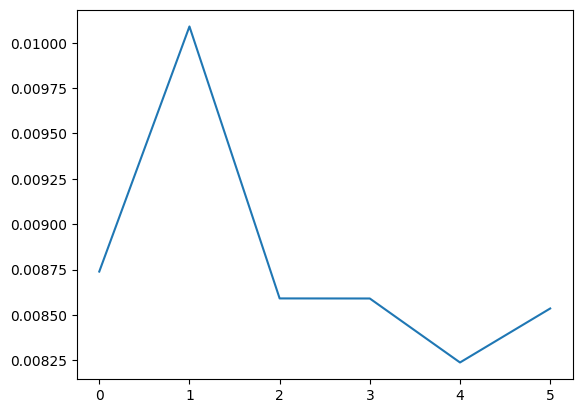

In [57]:
#plot val loss
# plt.plot(val_loss)
#plot train loss
plt.plot(train_loss)
plt.show()